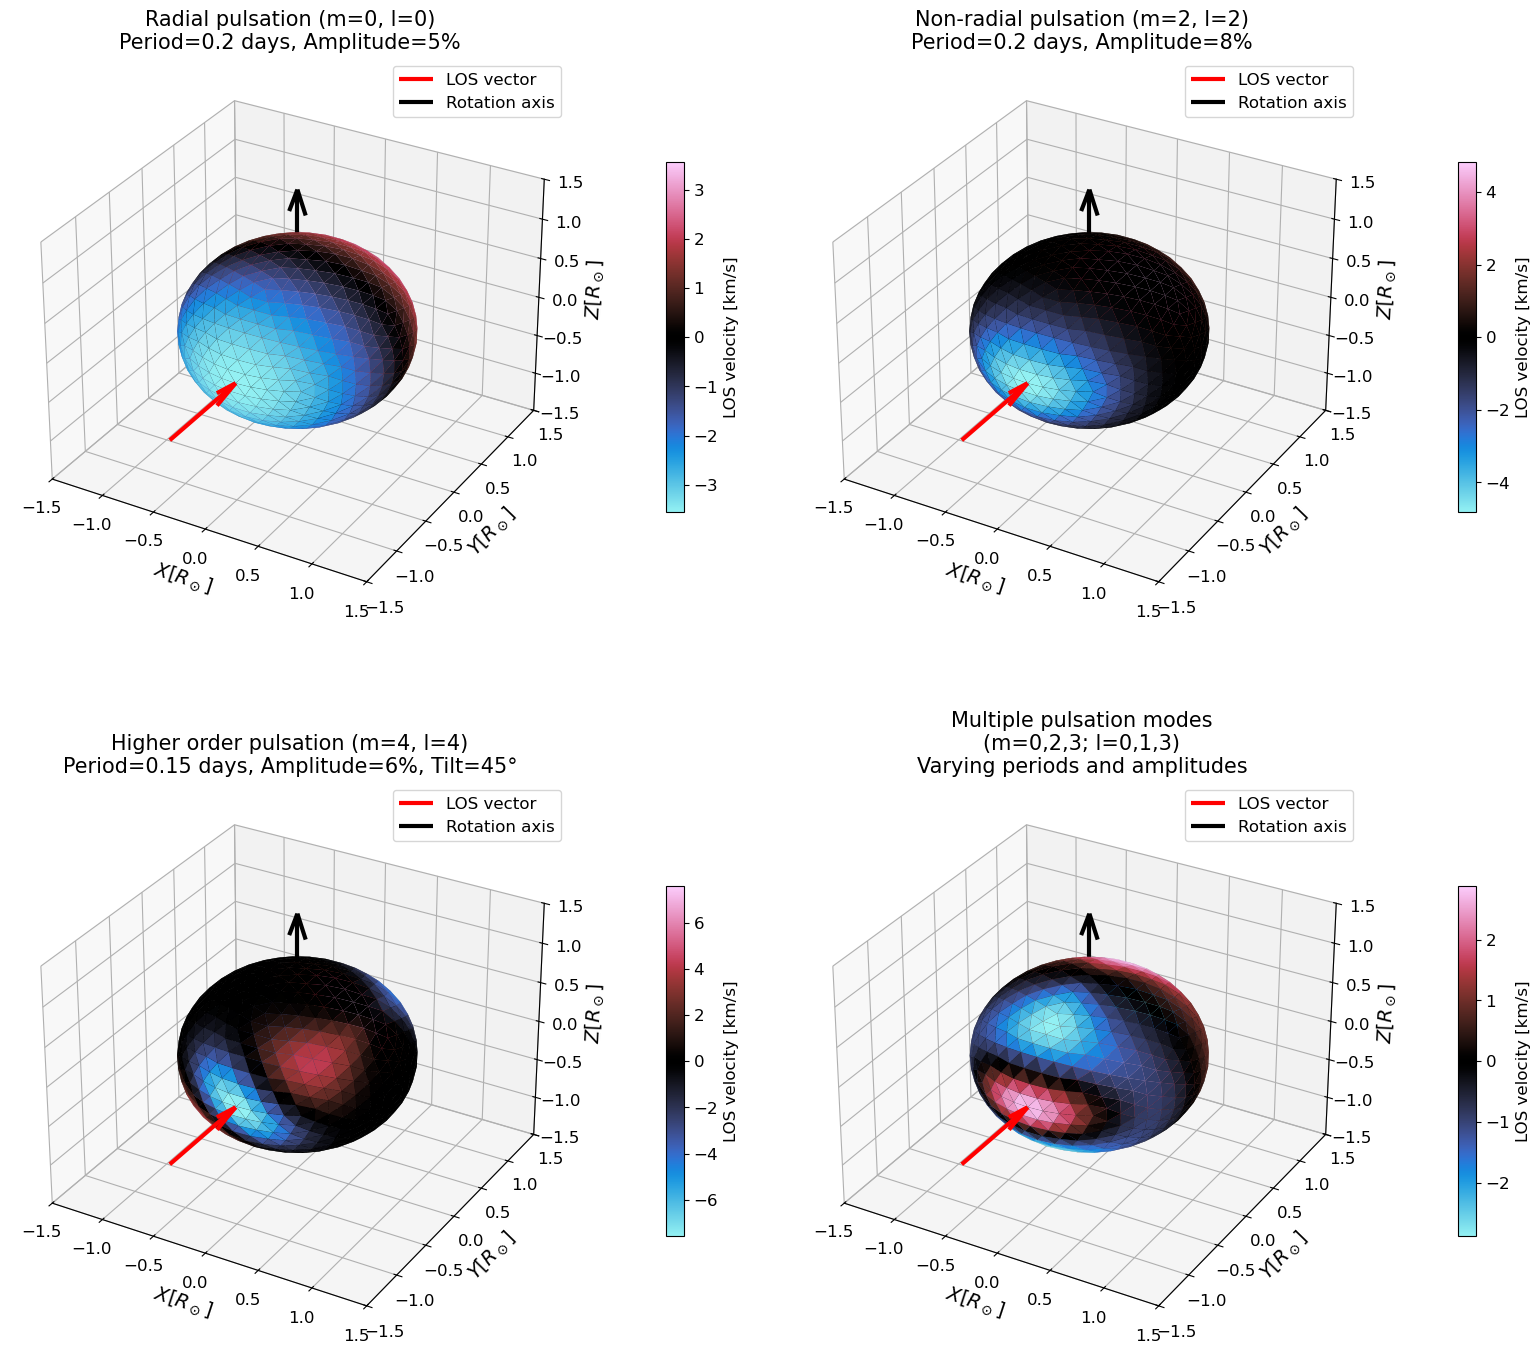

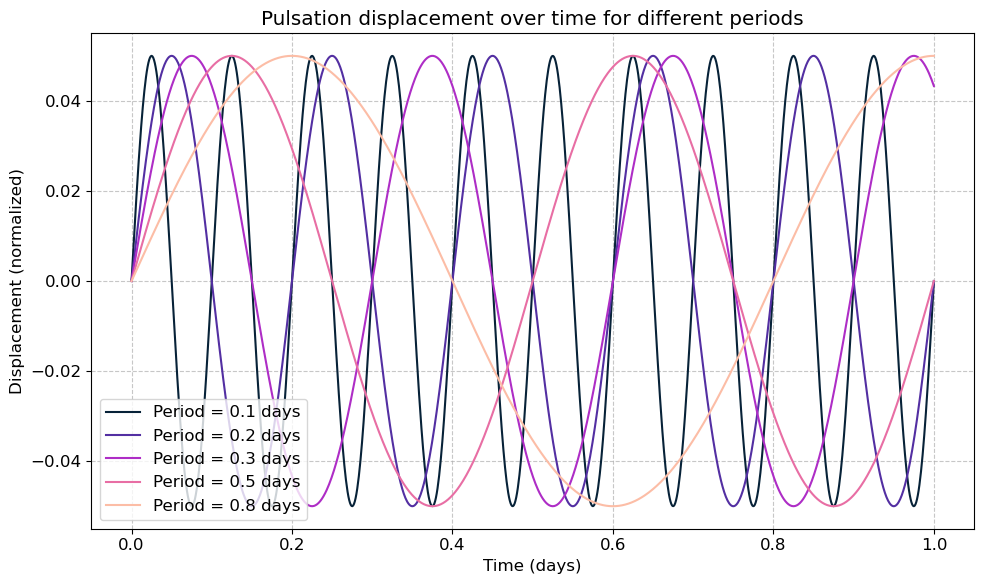

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import cmasher as cmr
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, add_pulsations, evaluate_pulsations, reset_pulsations
from spice.plots import plot_3D
from transformer_payne import Blackbody

# Set up the notebook for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

from transformer_payne import TransformerPayne
tp = TransformerPayne.download()

EV_TIME = 0.05

# Create base model with temperature of 5700K
base_temp = 5700
m = IcosphereModel.construct(1000, 1., 1., tp.to_parameters(), tp.stellar_parameter_names)

# Create a 2x2 grid of pulsation configurations
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes = [
    [fig.add_subplot(2, 2, 1, projection='3d'), fig.add_subplot(2, 2, 2, projection='3d')],
    [fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4, projection='3d')]
]

# Configuration 1: Simple radial pulsation (m=0, n=0)
m_pulsation1_ev = add_pulsation(
    m,
    m_order=jnp.array([0]),
    n_degree=jnp.array([0]),
    period=jnp.array([0.2]),  # 0.1 day period
    fourier_series_parameters=jnp.array([[0.05, 0.0]])  # Simple sine wave with 5% amplitude
)
m_pulsation1 = evaluate_pulsations(m_pulsation1_ev, EV_TIME)
ax1 = plot_3D(m_pulsation1, property='los_velocities', axes=(fig, axes[0][0]), property_label="LOS velocity [km/s]", cmap='cmr.redshift')
axes[0][0].set_title(f"Radial pulsation (m=0, l=0)\nPeriod=0.2 days, Amplitude=5%", fontsize=15)

# Configuration 2: Non-radial pulsation (m=2, n=2)
m_pulsation2_ev = add_pulsations(
    m,
    m_orders=jnp.array([2]),
    n_degrees=jnp.array([2]),
    periods=jnp.array([0.2]),  # 0.2 day period
    fourier_series_parameters=jnp.array([[0.05, 0.0]])  # Simple sine wave with 8% amplitude
)
m_pulsation2 = evaluate_pulsations(m_pulsation2_ev, EV_TIME)
ax2 = plot_3D(m_pulsation2, property='los_velocities', axes=(fig, axes[0][1]), property_label="LOS velocity [km/s]", cmap='cmr.redshift')
axes[0][1].set_title(f"Non-radial pulsation (m=2, l=2)\nPeriod=0.2 days, Amplitude=8%", fontsize=15)

# Configuration 3: Higher order non-radial pulsation (m=4, n=4)
m_pulsation3_ev = add_pulsations(
    m,
    m_orders=jnp.array([4]),
    n_degrees=jnp.array([4]),
    periods=jnp.array([0.15]),  # 0.15 day period
    fourier_series_parameters=jnp.array([[0.06, 0.0]]),  # Simple sine wave with 6% amplitude
    pulsation_axes=jnp.array([[0.0, 1.0, 0.0]]),
    pulsation_angles=jnp.array([45.0])  # 45 degree tilt
)
m_pulsation3 = evaluate_pulsations(m_pulsation3_ev  , EV_TIME)
ax3 = plot_3D(m_pulsation3, property='los_velocities', axes=(fig, axes[1][0]), property_label="LOS velocity [km/s]", cmap='cmr.redshift')
axes[1][0].set_title(f"Higher order pulsation (m=4, l=4)\nPeriod=0.15 days, Amplitude=6%, Tilt=45°", fontsize=15)

# Configuration 4: Multiple pulsation modes
m_pulsation4_ev = add_pulsations(
    m,
    m_orders=jnp.array([0, 2, 3]),
    n_degrees=jnp.array([0, 1, 3]),
    periods=jnp.array([0.15, 0.1, 0.2]),  # Different periods
    fourier_series_parameters=jnp.array([
        [0.03, 0.0],  # First mode
        [0.04, 0.0],  # Second mode
        [0.05, 0.0]  # Third mode
    ])
)
m_pulsation4 = evaluate_pulsations(m_pulsation4_ev, EV_TIME)
ax4 = plot_3D(m_pulsation4, property='los_velocities', axes=(fig, axes[1][1]), property_label="LOS velocity [km/s]", cmap='cmr.redshift')
axes[1][1].set_title(f"Multiple pulsation modes\n(m=0,2,3; l=0,1,3)\nVarying periods and amplitudes", fontsize=15)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Create a figure to demonstrate how pulsation amplitude varies with different periods
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Define a range of time points
time_points = np.linspace(0, 1, 1000)  # 1 day

# Define different periods to plot
periods = [0.1, 0.2, 0.3, 0.5, 0.8]
colors = cmr.bubblegum(np.linspace(0, 1, len(periods)))

for i, period in enumerate(periods):
    # Simple sine wave with amplitude 0.05
    amplitude = 0.05
    displacement = amplitude * np.sin(2 * np.pi * time_points / period)
    ax2.plot(time_points, displacement, color=colors[i], label=f"Period = {period} days")

ax2.set_xlabel("Time (days)")
ax2.set_ylabel("Displacement (normalized)")
ax2.set_title("Pulsation displacement over time for different periods")
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()
plt.tight_layout()


In [7]:
vws = jnp.linspace(5000, 5002, 200)

In [25]:
models = []
times = jnp.linspace(0, 0.2, 100)

models.append([evaluate_pulsations(m_pulsation1_ev, t) for t in times])
models.append([evaluate_pulsations(m_pulsation2_ev, t) for t in times])
models.append([evaluate_pulsations(m_pulsation3_ev, t) for t in times])
models.append([evaluate_pulsations(m_pulsation4_ev, t) for t in times])

In [26]:
from spice.spectrum.spectrum import simulate_observed_flux
from tqdm import tqdm

spectra = []
for m in tqdm(models, desc="Calculating spectra", leave=False):
    spectra.append([simulate_observed_flux(tp.intensity, _m, jnp.log10(vws)) for _m in tqdm(m)])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.44s/it]


In [27]:
spectra = np.array(spectra)
spectra.shape

(4, 100, 200, 2)

# DOUBLE CHECK THE RESOLUTION

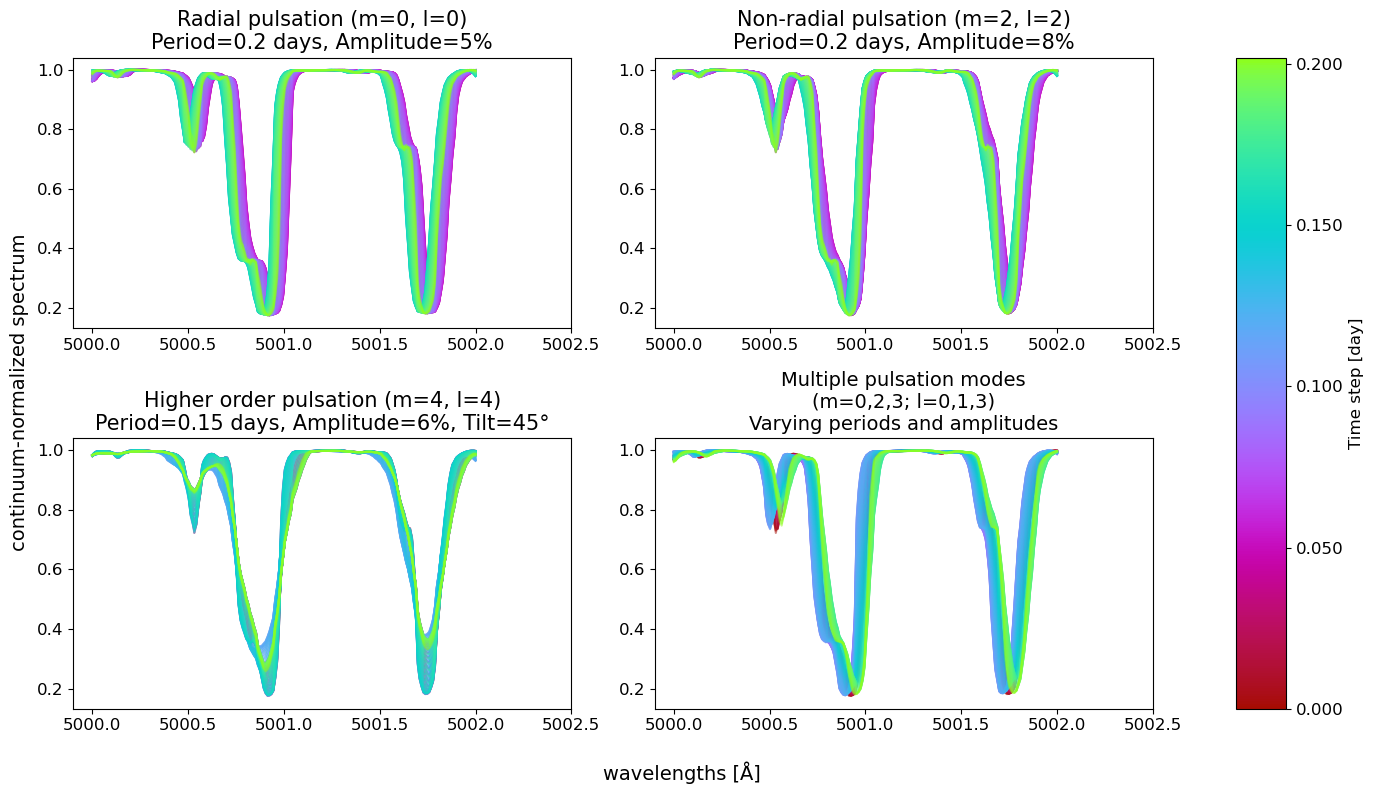

In [58]:
import cmasher as cmr

# Create figure with GridSpec to accommodate colorbar
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 3, width_ratios=[1, 1, 0.1], figure=fig)

# Create the 2x2 subplot grid in the first 2 columns
ax = []
ax.append(fig.add_subplot(gs[0, 0]))
ax.append(fig.add_subplot(gs[0, 1]))
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[1, 1]))

# Make all axes share x and y
for i in range(1, 4):
    ax[i].sharex(ax[0])
    ax[i].sharey(ax[0])

colors = cmr.neon(np.linspace(0, 1, len(spectra[0])))
for i, s in enumerate(spectra[0]):
    ax[0].plot(vws, s[:, 0]/s[:, 1], color=colors[i], alpha=0.5)
    
for i, s in enumerate(spectra[1]):
    ax[1].plot(vws, s[:, 0]/s[:, 1], color=colors[i], alpha=0.5)
    
for i, s in enumerate(spectra[2]):
    ax[2].plot(vws, s[:, 0]/s[:, 1], color=colors[i], alpha=0.5)
    
for i, s in enumerate(spectra[3]):
    ax[3].plot(vws, s[:, 0]/s[:, 1], color=colors[i], alpha=0.5)
    
ax[3].set_title(f"Multiple pulsation modes\n(m=0,2,3; l=0,1,3)\nVarying periods and amplitudes", fontsize=14)

# Create a colorbar showing the time progression
norm = plt.Normalize(0, len(spectra[0]))
sm = plt.cm.ScalarMappable(cmap=cmr.neon, norm=norm)
sm.set_array([])

# Add colorbar in the third column
cbar_ax = fig.add_subplot(gs[:, 2])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Time step [day]', fontsize=12)
cbar.set_ticks(np.linspace(0, len(spectra[0])-1, 5))
cbar.set_ticklabels([f'{t:.3f}' for t in np.linspace(0, 0.2, 5)])

fig.supylabel("continuum-normalized spectrum", fontsize=14, x=0.02)
fig.supxlabel("wavelengths [Å]", fontsize=14)
ax[0].set_title(f"Radial pulsation (m=0, l=0)\nPeriod=0.2 days, Amplitude=5%", fontsize=15)
ax[1].set_title(f"Non-radial pulsation (m=2, l=2)\nPeriod=0.2 days, Amplitude=8%", fontsize=15)
ax[2].set_title(f"Higher order pulsation (m=4, l=4)\nPeriod=0.15 days, Amplitude=6%, Tilt=45°", fontsize=15)
ax[3].set_xticks(np.arange(vws.min(), vws.max()+1, 0.5))
fig.tight_layout()
